# **Semantic Segmentation**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import pathlib
from PIL import Image

# **Full Pipeline**

## **Loss Function**

In [2]:
import cv2
import os
import tensorflow.keras.backend as K

class LossFunctions:
    @staticmethod
    def tversky(y_true, y_pred):
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1-y_pred_pos))
        false_pos = K.sum((1-y_true_pos)*y_pred_pos)
        alpha = 0.7
        smooth = 1e-5
        return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

    @staticmethod
    def tversky_loss(y_true, y_pred):
        return 1 - LossFunctions.tversky(y_true,y_pred)

def categorical_focal_loss(gamma=2.0, alpha_val=None):
    def focal_loss(y_true, y_pred):
        """
        Categorical focal loss function.
        :param y_true: one-hot encoded true labels
        :param y_pred: predicted label probabilities
        :param gamma:
        :param alpha:
        :return:
        """
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)

        if alpha_val is not None:
            alpha = K.constant(alpha_val)
            class_weights = K.sum(alpha * y_true, axis=-1)
            class_weights = K.expand_dims(class_weights, axis=-1)
            focal_weights = class_weights * K.pow(1 - y_pred, gamma)
            loss = focal_weights * cross_entropy
        else:
            focal_weights = K.pow(1 - y_pred, gamma)
            loss = focal_weights * cross_entropy

        return K.mean(loss)

    return focal_loss

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pos_weight = alpha * y_true + (1 - alpha) * (1 - y_true)
        focal_weights = pos_weight * K.pow(1 - y_pred, gamma)
        loss = focal_weights * K.binary_crossentropy(y_true, y_pred)
        return K.mean(loss)
    return focal_loss

def weighted_binary_crossentropy(pos_weight=0.25):
    def weighted_bce(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        loss = pos_weight * y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)
        return -K.mean(loss)
    return weighted_bce

## **Creating new folders for only binary**

In this code we create two new folders, one for only mask vegetation and one for only mask power line.

In [3]:
def create_binary_veg_mask(path):
    folder_path = f"{path}/MASK"
    # Crear una nueva carpeta para las imágenes binarias
    dataset_name = os.path.basename(path)
    binary_folder_path = f"/kaggle/working/{dataset_name}/MASK_NEW_VEGETATION"

    if not os.path.exists(binary_folder_path):
        os.makedirs(binary_folder_path, exist_ok=True)

    # Leer cada archivo en la carpeta y procesar
    for filename in os.listdir(folder_path):
      # Cargar la imagen y convertir a escala de grises
      img = cv2.imread(os.path.join(folder_path, filename))
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Aplicar la umbralización
      _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

      # Convertir los píxeles verde (vegetación) en blanco y los píxeles grises (líneas eléctricas) en negro
      thresh[(img[:, :, 1] == 255) & (img[:, :, 0] == 0)] = 255
      thresh[(img[:, :, 0] == img[:, :, 1]) & (img[:, :, 0] == img[:, :, 2]) & (img[:, :, 0] != 0)] = 0

      # Guardar la imagen binaria en la nueva carpeta
      cv2.imwrite(os.path.join(binary_folder_path, filename), thresh)

def create_binary_powerline_mask(path):
    folder_path = f"{path}/MASK"
    # Crear una nueva carpeta para las imágenes binarias
    dataset_name = os.path.basename(path)
    binary_folder_path = f"/kaggle/working/{dataset_name}/MASK_NEW_POWERLINE"
    
    if not os.path.exists(binary_folder_path):
        os.makedirs(binary_folder_path, exist_ok=True)
    
    # Leer cada archivo en la carpeta y procesar
    for filename in os.listdir(folder_path):
      # Cargar la imagen y convertir a escala de grises
      img = cv2.imread(os.path.join(folder_path, filename))
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Aplicar la umbralización
      _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

      # Convertir los píxeles (110, 110, 110) en blanco y todo lo demás en negro
      thresh[(img[:, :, 0] == 110) & (img[:, :, 1] == 110) & (img[:, :, 2] == 110)] = 255
      thresh[(img[:, :, 0] != 110) | (img[:, :, 1] != 110) | (img[:, :, 2] != 110)] = 0

      # Guardar la imagen binaria en la nueva carpeta
      cv2.imwrite(os.path.join(binary_folder_path, filename), thresh)



## **Creation of dataset for training**

In [4]:
def load_and_preprocess_image(image_path, mask_path):
        # cargar la imagen y máscara
        image = tf.io.decode_png(tf.io.read_file(image_path))
        mask = tf.io.decode_png(tf.io.read_file(mask_path), channels=1)

        # normalizar la imagen y máscara
        image = tf.cast(image, tf.float32) / 255.0
        mask = tf.cast(mask, tf.float32) / 255.0

        return image, mask
    
def dataset_creation(path, class_train, batch_size):
    BATCH_SIZE = batch_size
    BUFFER_SIZE = 100
    
    data_dir = pathlib.Path(f'{path}/')
    images_dir = data_dir / 'RGB'
    dataset_name = os.path.basename(path)
    data_mask_dir = pathlib.Path(f"/kaggle/working/{dataset_name}/")
    
    if class_train=='vegetation':
        masks_dir = data_mask_dir / "MASK_NEW_VEGETATION"
    
    elif class_train=='powerline':
        masks_dir = data_mask_dir / "MASK_NEW_POWERLINE"
    
    else:
        print("Class doesn't exists")

    # obtener una lista de rutas de archivo para imágenes y máscaras
    image_paths = sorted([str(path) for path in images_dir.glob('*.png')])
    mask_paths = sorted([str(path) for path in masks_dir.glob('*.png')])

    # crear un dataset a partir de las rutas de archivo
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    
    # aplicar la función de carga y preprocesamiento a cada par de rutas de archivo en el dataset
    dataset = dataset.map(load_and_preprocess_image)

    # dividir el dataset en conjuntos de entrenamiento, validación y prueba
    total_samples = len(image_paths)
    train_size = int(0.8 * total_samples)
    val_size = int(0.1 * total_samples)
    test_size = total_samples - train_size - val_size

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size).take(test_size)

    train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    validation_batches = test_dataset.batch(BATCH_SIZE)
    test_batches = test_dataset.batch(BATCH_SIZE)
    
    return train_batches,validation_batches, test_batches
    

## **Creation of UNet**

In [5]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

def Unet(image_size):
    vgg_weight_path = None
    inputs = Input((image_size, image_size, 3))
    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(inputs, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    outputs = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

## **Creation of VGG Unet**

In [6]:
import urllib.request

url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
filename = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
urllib.request.urlretrieve(url, filename)
vgg_weight_path = filename

In [7]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

def VGGUnet(image_size):
    vgg_weight_path = '/kaggle/working/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    inputs = Input((image_size, image_size, 3))
    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(inputs, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    outputs = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

## **Creation of DeepLab V3+**

In [8]:
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import Input, DepthwiseConv2D, add,Dropout, AveragePooling2D, Concatenate, Layer, InputSpec
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils import conv_utils
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.utils import conv_utils

from keras.utils.data_utils import get_file
from keras.utils.conv_utils import normalize_data_format
#keras.utils.conv_utils.normalize_data_format




class BilinearUpsampling(Layer):

    def __init__(self, upsampling=(2, 2), data_format=None, **kwargs):
        super(BilinearUpsampling, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        self.upsampling = conv_utils.normalize_tuple(upsampling, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        height = self.upsampling[0] * \
                 input_shape[1] if input_shape[1] is not None else None
        width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        return (input_shape[0], height, width, input_shape[3])

    def call(self, inputs):
        # .tf
        return tf.image.resize_bilinear(inputs, (int(inputs.shape[1] * self.upsampling[0]),
                                                 int(inputs.shape[2] * self.upsampling[1])))

    def get_config(self):

        config = {'size': self.upsampling, 'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def xception_downsample_block(x, channels, top_relu=False):
    ##separable conv1
    if top_relu:
        x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    ##separable conv2
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    ##separable conv3
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def res_xception_downsample_block(x, channels):
    res = Conv2D(channels, (1, 1), strides=(2, 2), padding="same", use_bias=False)(x)
    res = BatchNormalization()(res)
    x = xception_downsample_block(x, channels)
    x = add([x, res])
    return x


def xception_block(x, channels):
    ##separable conv1
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    ##separable conv2
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    ##separable conv3
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def res_xception_block(x, channels):
    res = x
    x = xception_block(x, channels)
    x = add([x, res])
    return x


def aspp(x, input_shape, out_stride):
    b0 = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    b0 = BatchNormalization()(b0)
    b0 = Activation("relu")(b0)

    b1 = DepthwiseConv2D((3, 3), dilation_rate=(6, 6), padding="same", use_bias=False)(x)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b1 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b1)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)

    b2 = DepthwiseConv2D((3, 3), dilation_rate=(12, 12), padding="same", use_bias=False)(x)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    b2 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b2)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)

    b3 = DepthwiseConv2D((3, 3), dilation_rate=(12, 12), padding="same", use_bias=False)(x)
    b3 = BatchNormalization()(b3)
    b3 = Activation("relu")(b3)
    b3 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b3)
    b3 = BatchNormalization()(b3)
    b3 = Activation("relu")(b3)

    out_shape = int(input_shape[0] / out_stride)
    b4 = AveragePooling2D(pool_size=(out_shape, out_shape))(x)
    b4 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b4)
    b4 = BatchNormalization()(b4)
    b4 = Activation("relu")(b4)
    #b4 = BilinearUpsampling((out_shape, out_shape))(b4)
    b4 = UpSampling2D(size=(out_shape, out_shape), interpolation='bilinear')(b4)


    x = Concatenate()([b4, b0, b1, b2, b3])
    return x


def DeeplabV3_plus(image_size):
    img_input = Input((image_size, image_size, 3))
    input_height=image_size
    input_width=image_size
    nClasses = 2
    out_stride=16
    x = Conv2D(32, (3, 3), strides=(2, 2), padding="same", use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = res_xception_downsample_block(x, 128)

    res = Conv2D(256, (1, 1), strides=(2, 2), padding="same", use_bias=False)(x)
    res = BatchNormalization()(res)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    skip = BatchNormalization()(x)
    x = Activation("relu")(skip)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x, res])

    x = xception_downsample_block(x, 728, top_relu=True)

    for i in range(16):
        x = res_xception_block(x, 728)

    res = Conv2D(1024, (1, 1), padding="same", use_bias=False)(x)
    res = BatchNormalization()(res)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(728, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x, res])

    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1536, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1536, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(2048, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # aspp
    x = aspp(x, (input_height, input_width, 3), out_stride)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.9)(x)

    ##decoder
    #x = BilinearUpsampling((4, 4))(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    dec_skip = Conv2D(48, (1, 1), padding="same", use_bias=False)(skip)
    dec_skip = BatchNormalization()(dec_skip)
    dec_skip = Activation("relu")(dec_skip)
    x = Concatenate()([x, dec_skip])

    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(nClasses, (1, 1), padding="same")(x)
    #x = BilinearUpsampling((4, 4))(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    outputHeight = Model(img_input, x).output_shape[1]
    outputWidth = Model(img_input, x).output_shape[2]
    x = (Reshape((outputHeight * outputWidth, nClasses)))(x)
    #x = Activation('softmax')(x)
    #model = Model(img_input, x)  # changed from Model(input=img_input, output=x)
    #model.outputHeight = outputHeight
    #model.outputWidth = outputWidth
    
    outputs = Activation('sigmoid')(x)

    model = Model(inputs=img_input, outputs=outputs)
    return model

In [9]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size):
    num_classes = 1
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    
    x = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    outputs = Activation('sigmoid')(x)
    return keras.Model(inputs=model_input, outputs=outputs)

model_test = DeeplabV3Plus(image_size=256)

94765736/94765736 [==============================] - 1s 0us/step


## **Function for run models according to path**

In [10]:
def run_models(path,model, loss_function, num_epochs, batch_size):      
    #load datasets
    total_samples = len(os.listdir(f'{path}/MASK'))
    train_size = int(0.8 * total_samples)
    val_size = int(0.1 * total_samples)
    test_size = total_samples - train_size - val_size

    NUM_EPOCHS = num_epochs
    BATCH_SIZE = batch_size
    STEPS_PER_EPOCH = total_samples // BATCH_SIZE
    VAL_SUBSPLITS = 5
    VALIDATION_STEPS = test_size // BATCH_SIZE // VAL_SUBSPLITS
    dataset_name = os.path.basename(path)
    model_folder = '/kaggle/working/models/'
    metrics_folder = '/kaggle/working/metrics/'
    
    if not os.path.exists(model_folder):
        os.makedirs(model_folder, exist_ok=True)
    
    if not os.path.exists(metrics_folder):
        os.makedirs(metrics_folder, exist_ok=True)
    
    callbacks_veg = [
                EarlyStopping(patience=10, verbose=1),
                ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
                ModelCheckpoint(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_veg.h5', verbose=1, save_best_only=True, save_weights_only=False),
                CSVLogger(f'/kaggle/working/metrics/{dataset_name}_{model_name}_{loss_name}_veg.csv'),
                TensorBoard(log_dir='./logs')
                ]
    
    callbacks_power = [
                EarlyStopping(patience=10, verbose=1),
                ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
                ModelCheckpoint(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_power.h5', verbose=1, save_best_only=True, save_weights_only=False),
                CSVLogger(f'/kaggle/working/metrics/{dataset_name}_{model_name}_{loss_name}_power.csv'),
                TensorBoard(log_dir='./logs')
                ]

    train_batches_veg, validation_batches_veg, test_batches_veg = dataset_creation(path, class_train = 'vegetation', batch_size = 8)
    train_batches_power, validation_batches_power, test_batches_power = dataset_creation(path, class_train = 'powerline', batch_size = 8)
    
    #load metrics
    metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
    
    model_2 = model
    
    model_veg = model.compile(optimizer=Adam(), loss=loss_function, metrics=metrics)
    model_power = model_2.compile(optimizer=Adam(), loss=loss_function, metrics=metrics)
    
    model_history_veg = model.fit(train_batches_veg,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches_veg,
                               callbacks=callbacks_veg)
    
    model_history_power = model_2.fit(train_batches_power,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches_power,
                               callbacks=callbacks_power)
    
    

## **Metrics**

In [11]:
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import f1_score, jaccard_score

    
def metrics_models(model, type_prediction, test_batches):    
    """ Prediction & Evaluation """
    SCORE = []
    threshold = 0.3
    num_classes = 2
    
    if type_prediction=='vegetation':
        classes = [
            "background", "vegetation"
        ]
    elif type_prediction=='power_line':
        classes = [
            "background", "power_line"
        ]

    for image, mask in test_batches:
        pred_mask = model.predict(image)
        pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
        pred = tf.where(pred_mask > threshold, 1.0, 0.0)

        labels = list(np.unique(pred))
        flat_mask = tf.reshape(mask,[-1])
        flat_pred = tf.reshape(pred, [-1])

        mask_arr = flat_mask.numpy().flatten()
        pred_arr = flat_pred.numpy().flatten()


        """ Calculating the metrics values """
        f1_value = f1_score(mask_arr, pred_arr, labels=labels, average=None, zero_division=0)
        jac_value = jaccard_score(mask_arr, pred_arr, labels=labels, average=None, zero_division=0)

        SCORE.append([f1_value, jac_value])

    score = np.array(SCORE)
    score = np.mean(score, axis=0)

    l = ["Class", "F1", "Jaccard"]
    print(f"{l[0]:15s} {l[1]:10s} {l[2]:10s}")
    print("-"*35)

    for i in range(num_classes):
        class_name = classes[i]
        f1 = score[0, i]
        jac = score[1, i]
        dstr = f"{class_name:15s}: {f1:1.5f} - {jac:1.5f}"
        print(dstr)

    print("-"*35)
    class_mean = np.mean(score, axis=-1)
    class_name = "Mean"

    f1 = class_mean[0]
    jac = class_mean[1]

    dstr = f"{class_name:15s}: {f1:1.5f} - {jac:1.5f}"
    print(dstr)

## **Visualization of predictions**

In [12]:
def create_mask(pred_mask, threshold=0.25):
  pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
  pred_mask = tf.where(pred_mask > threshold, 1.0, 0.0)  # usar float para el threshold
  return pred_mask[0]

def show_predictions(dataset, model, num):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

## **First run**

In [13]:
image_size = 256
tversky_loss_fn = LossFunctions.tversky_loss

list_folders = ['/kaggle/input/tesellated-without-augmentation/TESELLATED_WITHOUT_AUGMENTATION',
               '/kaggle/input/tesellated-with-geometric-augmentation/TESELLATED_WITH_GEOMETRIC_AUGMENTATION',
               '/kaggle/input/tesellated-with-spectral-augmentation/TESELLATED_WITH_SPECTRAL_AUGMENTATION']
models_dict = {
    'unet': Unet(image_size)
}

loss_dict = {'tversky': tversky_loss_fn}

In [14]:
for path in list_folders:
    create_binary_veg_mask(path)
    create_binary_powerline_mask(path)

In [15]:
# Register custom loss function
custom_objects = {'tversky_loss': LossFunctions.tversky_loss}

### **tesellated-with-geometric-augmentation**

### **Unet**

In [13]:
models_dict = {'unet': Unet(image_size)}
loss_dict = {'tversky': tversky_loss_fn}
path = '/kaggle/input/tesellated-with-geometric-augmentation/TESELLATED_WITH_GEOMETRIC_AUGMENTATION'
loss = LossFunctions.tversky_loss
epochs = 15
batch_size = 8

for model_name, model in models_dict.items():
    for loss_name, loss in loss_dict.items():
            run_models(path,model, loss, epochs, batch_size)

Epoch 1/15
465/465 [==============================] - ETA: 0s - loss: 0.3169 - accuracy: 0.7936 - auc_1: 0.8556 - sensitivity_at_specificity_1: 0.9561 - specificity_at_sensitivity_1: 0.8993
Epoch 1: val_loss improved from inf to 0.25751, saving model to /kaggle/working/models/TESELLATED_WITH_GEOMETRIC_AUGMENTATION_vgg_tversky_veg.h5
465/465 [==============================] - 283s 574ms/step - loss: 0.3169 - accuracy: 0.7936 - auc_1: 0.8556 - sensitivity_at_specificity_1: 0.9561 - specificity_at_sensitivity_1: 0.8993 - val_loss: 0.2575 - val_accuracy: 0.7634 - val_auc_1: 0.8217 - val_sensitivity_at_specificity_1: 0.8937 - val_specificity_at_sensitivity_1: 0.8868 - lr: 0.0010
Epoch 2/15
465/465 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.7957 - auc_1: 0.8719 - sensitivity_at_specificity_1: 0.9617 - specificity_at_sensitivity_1: 0.9135
Epoch 2: val_loss improved from 0.25751 to 0.22526, saving model to /kaggle/working/models/TESELLATED_WITH_GEOMETRIC_AUGMENTATI

Load models to predict

In [14]:
from keras.models import Sequential, load_model


dataset_name = 'TESELLATED_WITH_GEOMETRIC_AUGMENTATION'
model_name = 'unet'
loss_name = 'tversky'

# Load model with registered custom objects
model_veg = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_veg.h5', custom_objects=custom_objects)
model_power = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_power.h5', custom_objects=custom_objects)

train_batches_veg, validation_batches_veg, test_batches_veg = dataset_creation(path, class_train = 'vegetation', batch_size = 8)
train_batches_power, validation_batches_power, test_batches_power = dataset_creation(path, class_train = 'powerline', batch_size = 8)

#### **Metrics for power_line**

In [16]:
metrics_models(model = model_power, type_prediction = 'power_line', test_batches = test_batches_power)

1/1 [==============================] - 3s 3s/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.98650 - 0.97354
power_line     : 0.39692 - 0.25352
-----------------------------------
Mean           : 0.69171 - 0.61353


In [ ]:
show_predictions(dataset = test_batches_power, model = model_power, num = 5)

#### **Metrics for vegetation**

In [18]:
metrics_models(model = model_veg, type_prediction = 'vegetation', test_batches = test_batches_veg)

1/1 [==============================] - 0s 26ms/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.48605 - 0.35837
vegetation     : 0.81381 - 0.71129
-----------------------------------
Mean           : 0.64993 - 0.53483


In [ ]:
show_predictions(dataset = test_batches_veg, model = model_veg, num = 5)

## **Union of both models**

In [37]:
import tensorflow as tf
import cv2
import numpy as np

# Cargar los pesos pre-entrenados de las dos redes neuronales
#model_vegetacion = tf.keras.models.load_model("modelo_vegetacion.h5")
#model_linea_electrica = tf.keras.models.load_model("modelo_linea_electrica.h5")

for image, mask in test_batches_veg.skip(100).take(1):

    # Realizar la segmentación semántica para obtener las dos máscaras
    mask_vegetacion = model_veg.predict(image)
    mask_vegetacion = create_mask(mask_vegetacion, threshold=0.25)
    mask_linea_electrica = model_power.predict(image)
    mask_linea_electrica = create_mask(mask_linea_electrica, threshold=0.25)

In [38]:
combined_mask = np.zeros_like(image.numpy()[0])
combined_mask[np.squeeze(mask_vegetacion == 1), :] = (0, 255, 0) # verde para mask_vegetacion
combined_mask[np.squeeze(mask_linea_electrica == 1), :] = (110, 110, 110) # gris para mask_linea_electrica
final_image = cv2.addWeighted(image.numpy()[0], 0.5, combined_mask, 0.5, 0)

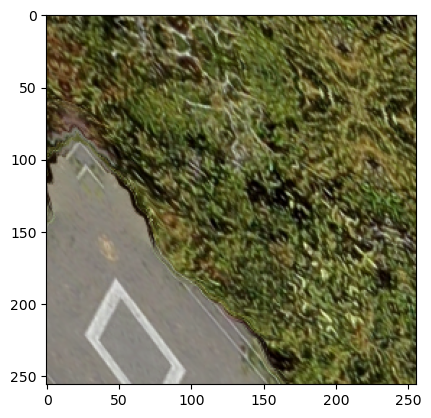

In [39]:
plt.imshow(image[0])
plt.show()

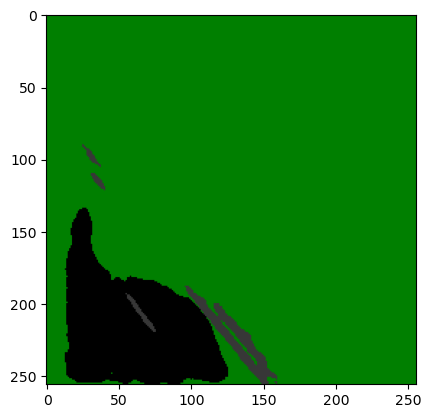

In [36]:
final_image = np.array(final_image, dtype=np.uint8)

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()

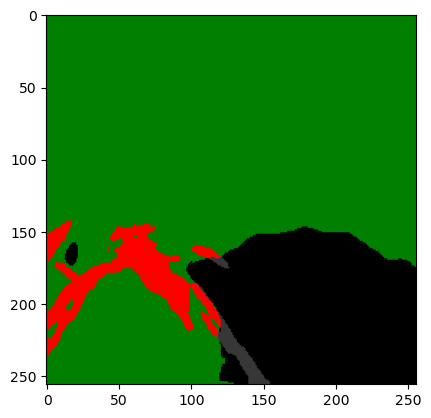

In [32]:
# Crear una máscara para los píxeles que son verdes o grises
mask_combined = np.logical_and(mask_vegetacion, mask_linea_electrica)
mask_combined = np.squeeze(mask_combined)

# Convertir la imagen a un array de numpy y cambiar el tipo de dato a uint8
final_image = np.array(final_image, dtype=np.uint8)

# Aplicar la máscara a la imagen original
final_image[mask_combined, :] = [255, 0, 0]  # Rojo: [R, G, B]

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


### **VGG Unet**

In [17]:
models_dict = {'vgg': VGGUnet(image_size)}
loss_dict = {'tversky': tversky_loss_fn}
path = '/kaggle/input/tesellated-with-geometric-augmentation/TESELLATED_WITH_GEOMETRIC_AUGMENTATION'
loss = LossFunctions.tversky_loss
epochs = 15
batch_size = 8

for model_name, model in models_dict.items():
    for loss_name, loss in loss_dict.items():
            run_models(path,model, loss, epochs, batch_size)

Epoch 1/15
465/465 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.8091 - auc: 0.8731 - sensitivity_at_specificity: 0.9624 - specificity_at_sensitivity: 0.9140
Epoch 1: val_loss improved from inf to 0.20588, saving model to /kaggle/working/models/TESELLATED_WITH_GEOMETRIC_AUGMENTATION_vgg_tversky_veg.h5
465/465 [==============================] - 285s 544ms/step - loss: 0.3089 - accuracy: 0.8091 - auc: 0.8731 - sensitivity_at_specificity: 0.9624 - specificity_at_sensitivity: 0.9140 - val_loss: 0.2059 - val_accuracy: 0.7739 - val_auc: 0.8570 - val_sensitivity_at_specificity: 0.9384 - val_specificity_at_sensitivity: 0.9215 - lr: 0.0010
Epoch 2/15
465/465 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.8235 - auc: 0.8880 - sensitivity_at_specificity: 0.9679 - specificity_at_sensitivity: 0.9216
Epoch 2: val_loss improved from 0.20588 to 0.20256, saving model to /kaggle/working/models/TESELLATED_WITH_GEOMETRIC_AUGMENTATION_vgg_tversky_veg.h5
46

Load models to predict

In [14]:
from keras.models import Sequential, load_model


dataset_name = 'TESELLATED_WITH_GEOMETRIC_AUGMENTATION'
model_name = 'unet'
loss_name = 'tversky'

# Load model with registered custom objects
model_veg = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_veg.h5', custom_objects=custom_objects)
model_power = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_power.h5', custom_objects=custom_objects)

train_batches_veg, validation_batches_veg, test_batches_veg = dataset_creation(path, class_train = 'vegetation', batch_size = 8)
train_batches_power, validation_batches_power, test_batches_power = dataset_creation(path, class_train = 'powerline', batch_size = 8)

#### **Metrics for power_line**

In [16]:
metrics_models(model = model_power, type_prediction = 'power_line', test_batches = test_batches_power)

1/1 [==============================] - 3s 3s/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.98650 - 0.97354
power_line     : 0.39692 - 0.25352
-----------------------------------
Mean           : 0.69171 - 0.61353


In [ ]:
show_predictions(dataset = test_batches_power, model = model_power, num = 5)

#### **Metrics for vegetation**

In [18]:
metrics_models(model = model_veg, type_prediction = 'vegetation', test_batches = test_batches_veg)

1/1 [==============================] - 0s 26ms/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.48605 - 0.35837
vegetation     : 0.81381 - 0.71129
-----------------------------------
Mean           : 0.64993 - 0.53483


In [ ]:
show_predictions(dataset = test_batches_veg, model = model_veg, num = 5)

## **Union of both models**

In [37]:
import tensorflow as tf
import cv2
import numpy as np

# Cargar los pesos pre-entrenados de las dos redes neuronales
#model_vegetacion = tf.keras.models.load_model("modelo_vegetacion.h5")
#model_linea_electrica = tf.keras.models.load_model("modelo_linea_electrica.h5")

for image, mask in test_batches_veg.skip(100).take(1):

    # Realizar la segmentación semántica para obtener las dos máscaras
    mask_vegetacion = model_veg.predict(image)
    mask_vegetacion = create_mask(mask_vegetacion, threshold=0.25)
    mask_linea_electrica = model_power.predict(image)
    mask_linea_electrica = create_mask(mask_linea_electrica, threshold=0.25)

In [38]:
combined_mask = np.zeros_like(image.numpy()[0])
combined_mask[np.squeeze(mask_vegetacion == 1), :] = (0, 255, 0) # verde para mask_vegetacion
combined_mask[np.squeeze(mask_linea_electrica == 1), :] = (110, 110, 110) # gris para mask_linea_electrica
final_image = cv2.addWeighted(image.numpy()[0], 0.5, combined_mask, 0.5, 0)

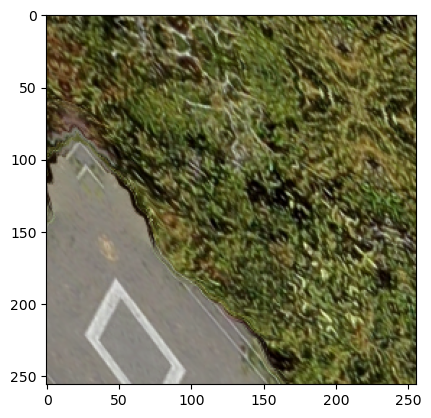

In [39]:
plt.imshow(image[0])
plt.show()

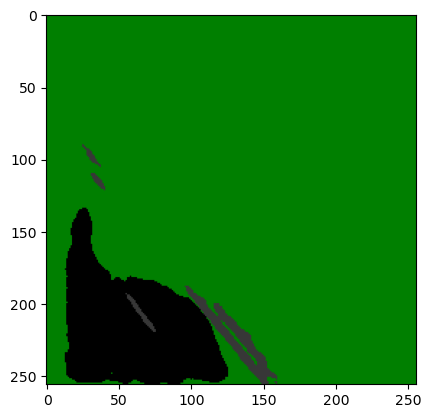

In [36]:
final_image = np.array(final_image, dtype=np.uint8)

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()

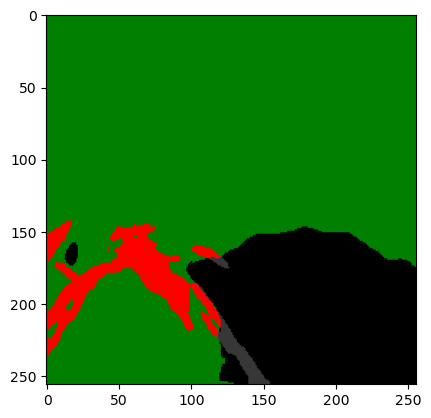

In [32]:
# Crear una máscara para los píxeles que son verdes o grises
mask_combined = np.logical_and(mask_vegetacion, mask_linea_electrica)
mask_combined = np.squeeze(mask_combined)

# Convertir la imagen a un array de numpy y cambiar el tipo de dato a uint8
final_image = np.array(final_image, dtype=np.uint8)

# Aplicar la máscara a la imagen original
final_image[mask_combined, :] = [255, 0, 0]  # Rojo: [R, G, B]

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


### **Using DeepLab**

In [14]:
models_dict = {'DeepLab': DeeplabV3Plus(image_size)}
loss_dict = {'tversky': tversky_loss_fn}
path = '/kaggle/input/tesellated-with-geometric-augmentation/TESELLATED_WITH_GEOMETRIC_AUGMENTATION'
loss = LossFunctions.tversky_loss
epochs = 15
batch_size = 8

for model_name, model in models_dict.items():
    for loss_name, loss in loss_dict.items():
            run_models(path,model, loss, epochs, batch_size)

Epoch 1/15
465/465 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.8326 - auc: 0.8939 - sensitivity_at_specificity: 0.9698 - specificity_at_sensitivity: 0.9294
Epoch 1: val_loss improved from inf to 0.36465, saving model to /kaggle/working/models/TESELLATED_WITH_GEOMETRIC_AUGMENTATION_DeepLab_tversky_veg.h5
465/465 [==============================] - 165s 247ms/step - loss: 0.3009 - accuracy: 0.8326 - auc: 0.8939 - sensitivity_at_specificity: 0.9698 - specificity_at_sensitivity: 0.9294 - val_loss: 0.3647 - val_accuracy: 0.6322 - val_auc: 0.5014 - val_sensitivity_at_specificity: 0.4875 - val_specificity_at_sensitivity: 0.4966 - lr: 0.0010
Epoch 2/15
465/465 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.8421 - auc: 0.9029 - sensitivity_at_specificity: 0.9753 - specificity_at_sensitivity: 0.9290
Epoch 2: val_loss did not improve from 0.36465
465/465 [==============================] - 109s 235ms/step - loss: 0.2337 - accuracy: 0.8421 - auc: 

Load models to predict

In [43]:
from keras.models import Sequential, load_model


dataset_name = 'TESELLATED_WITH_GEOMETRIC_AUGMENTATION'
model_name = 'DeepLab'
loss_name = 'tversky'

# Load model with registered custom objects
model_veg = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_veg.h5', custom_objects=custom_objects)
model_power = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_power.h5', custom_objects=custom_objects)

train_batches_veg, validation_batches_veg, test_batches_veg = dataset_creation(path, class_train = 'vegetation', batch_size = 8)
train_batches_power, validation_batches_power, test_batches_power = dataset_creation(path, class_train = 'powerline', batch_size = 8)

#### **Metrics for power_line**

In [44]:
metrics_models(model = model_power, type_prediction = 'power_line', test_batches = test_batches_power)

1/1 [==============================] - 2s 2s/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.94583 - 0.89971
power_line     : 0.19164 - 0.10816
-----------------------------------
Mean           : 0.56873 - 0.50393


In [ ]:
show_predictions(dataset = test_batches_power, model = model_power, num = 5)

#### **Metrics for vegetation**

In [45]:
metrics_models(model = model_veg, type_prediction = 'vegetation', test_batches = test_batches_veg)

1/1 [==============================] - 0s 33ms/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.74849 - 0.63103
vegetation     : 0.88152 - 0.80279
-----------------------------------
Mean           : 0.81500 - 0.71691


In [ ]:
show_predictions(dataset = test_batches_veg, model = model_veg, num = 5)

## **Union of both models**

In [53]:
import tensorflow as tf
import cv2
import numpy as np

# Cargar los pesos pre-entrenados de las dos redes neuronales
#model_vegetacion = tf.keras.models.load_model("modelo_vegetacion.h5")
#model_linea_electrica = tf.keras.models.load_model("modelo_linea_electrica.h5")

for image, mask in test_batches_veg.skip(5).take(1):

    # Realizar la segmentación semántica para obtener las dos máscaras
    mask_vegetacion = model_veg.predict(image)
    mask_vegetacion = create_mask(mask_vegetacion, threshold=0.25)
    mask_linea_electrica = model_power.predict(image)
    mask_linea_electrica = create_mask(mask_linea_electrica, threshold=0.25)

1/1 [==============================] - 0s 33ms/step


In [54]:
combined_mask = np.zeros_like(image.numpy()[0])
combined_mask[np.squeeze(mask_vegetacion == 1), :] = (0, 255, 0) # verde para mask_vegetacion
combined_mask[np.squeeze(mask_linea_electrica == 1), :] = (110, 110, 110) # gris para mask_linea_electrica
final_image = cv2.addWeighted(image.numpy()[0], 0.5, combined_mask, 0.5, 0)

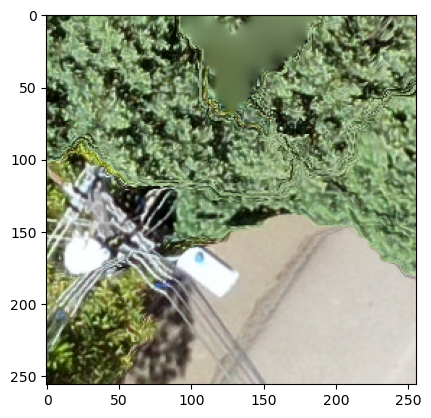

In [55]:
plt.imshow(image[0])
plt.show()

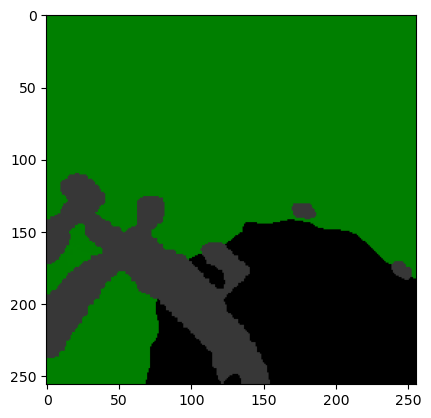

In [56]:
final_image = np.array(final_image, dtype=np.uint8)

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()

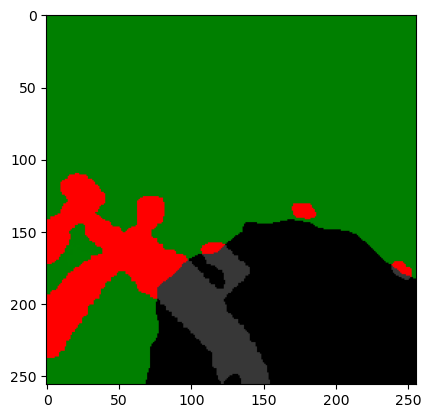

In [57]:
# Crear una máscara para los píxeles que son verdes o grises
mask_combined = np.logical_and(mask_vegetacion, mask_linea_electrica)
mask_combined = np.squeeze(mask_combined)

# Convertir la imagen a un array de numpy y cambiar el tipo de dato a uint8
final_image = np.array(final_image, dtype=np.uint8)

# Aplicar la máscara a la imagen original
final_image[mask_combined, :] = [255, 0, 0]  # Rojo: [R, G, B]

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


### **tesellated-without-augmentation**

# **Unet**

In [12]:
models_dict = {'unet': Unet(image_size)}
loss_dict = {'tversky': tversky_loss_fn}
path = '/kaggle/input/tesellated-without-augmentation/TESELLATED_WITHOUT_AUGMENTATION'
loss = LossFunctions.tversky_loss
epochs = 15
batch_size = 8

for model_name, model in models_dict.items():
    for loss_name, loss in loss_dict.items():
            run_models(path,model, loss, epochs, batch_size)

Epoch 1/15
66/66 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.7799 - auc: 0.8509 - sensitivity_at_specificity: 0.9461 - specificity_at_sensitivity: 0.9082
Epoch 1: val_loss improved from inf to 0.42372, saving model to /kaggle/working/models/TESELLATED_WITHOUT_AUGMENTATION_vgg_tversky_veg.h5
66/66 [==============================] - 76s 600ms/step - loss: 0.3583 - accuracy: 0.7799 - auc: 0.8509 - sensitivity_at_specificity: 0.9461 - specificity_at_sensitivity: 0.9082 - val_loss: 0.4237 - val_accuracy: 0.6217 - val_auc: 0.6884 - val_sensitivity_at_specificity: 0.6887 - val_specificity_at_sensitivity: 0.8355 - lr: 0.0010
Epoch 2/15
66/66 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.7951 - auc: 0.8709 - sensitivity_at_specificity: 0.9665 - specificity_at_sensitivity: 0.9188
Epoch 2: val_loss did not improve from 0.42372
66/66 [==============================] - 35s 529ms/step - loss: 0.3332 - accuracy: 0.7951 - auc: 0.8709 - sensitivity_

Load models to predict

In [16]:
from keras.models import Sequential, load_model

dataset_name = 'TESELLATED_WITHOUT_AUGMENTATION'
model_name = 'unet'
loss_name = 'tversky'

# Load model with registered custom objects
model_veg = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_veg.h5', custom_objects=custom_objects)
model_power = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_power.h5', custom_objects=custom_objects)

train_batches_veg, validation_batches_veg, test_batches_veg = dataset_creation(path, class_train = 'vegetation', batch_size = 8)
train_batches_power, validation_batches_power, test_batches_power = dataset_creation(path, class_train = 'powerline', batch_size = 8)

#### **Metrics for power_line**

In [17]:
metrics_models(model = model_power, type_prediction = 'power_line', test_batches = test_batches_power)

1/1 [==============================] - 3s 3s/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.89690 - 0.81420
power_line     : 0.11878 - 0.06384
-----------------------------------
Mean           : 0.50784 - 0.43902


In [ ]:
show_predictions(dataset = test_batches_power, model = model_power, num = 5)

#### **Metrics for vegetation**

In [19]:
metrics_models(model = model_veg, type_prediction = 'vegetation', test_batches = test_batches_veg)

1/1 [==============================] - 0s 30ms/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.62946 - 0.47532
vegetation     : 0.86898 - 0.76997
-----------------------------------
Mean           : 0.74922 - 0.62264


In [ ]:
show_predictions(dataset = test_batches_veg, model = model_veg, num = 5)

## **Union of both models**

In [30]:
import tensorflow as tf
import cv2
import numpy as np

# Cargar los pesos pre-entrenados de las dos redes neuronales
#model_vegetacion = tf.keras.models.load_model("modelo_vegetacion.h5")
#model_linea_electrica = tf.keras.models.load_model("modelo_linea_electrica.h5")

for image, mask in test_batches_veg.skip(1).take(1):

    # Realizar la segmentación semántica para obtener las dos máscaras
    mask_vegetacion = model_veg.predict(image)
    mask_vegetacion = create_mask(mask_vegetacion, threshold=0.25)
    mask_linea_electrica = model_power.predict(image)
    mask_linea_electrica = create_mask(mask_linea_electrica, threshold=0.25)

1/1 [==============================] - 0s 28ms/step


In [31]:
combined_mask = np.zeros_like(image.numpy()[0])
combined_mask[np.squeeze(mask_vegetacion == 1), :] = (0, 255, 0) # verde para mask_vegetacion
combined_mask[np.squeeze(mask_linea_electrica == 1), :] = (110, 110, 110) # gris para mask_linea_electrica
final_image = cv2.addWeighted(image.numpy()[0], 0.5, combined_mask, 0.5, 0)

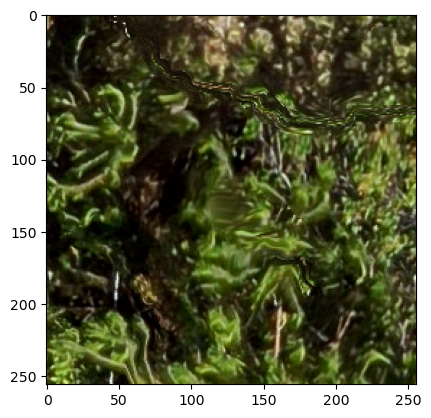

In [32]:
plt.imshow(image[0])
plt.show()

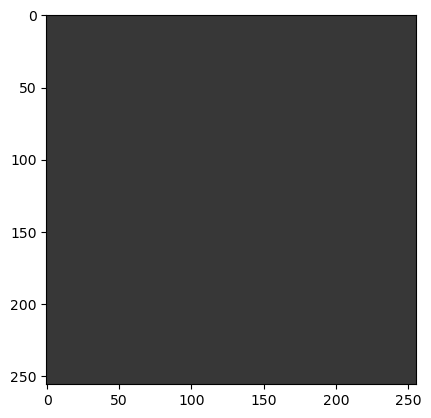

In [33]:
final_image = np.array(final_image, dtype=np.uint8)

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()

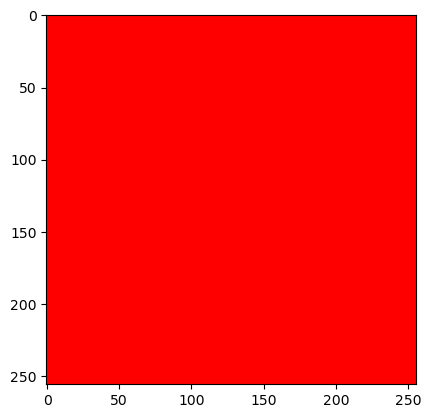

In [34]:
# Crear una máscara para los píxeles que son verdes o grises
mask_combined = np.logical_and(mask_vegetacion, mask_linea_electrica)
mask_combined = np.squeeze(mask_combined)

# Convertir la imagen a un array de numpy y cambiar el tipo de dato a uint8
final_image = np.array(final_image, dtype=np.uint8)

# Aplicar la máscara a la imagen original
final_image[mask_combined, :] = [255, 0, 0]  # Rojo: [R, G, B]

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


### **VGG Unet**

In [16]:
models_dict = {'vgg': VGGUnet(image_size)}
loss_dict = {'tversky': tversky_loss_fn}
path = '/kaggle/input/tesellated-without-augmentation/TESELLATED_WITHOUT_AUGMENTATION'
loss = LossFunctions.tversky_loss
epochs = 15
batch_size = 8

for model_name, model in models_dict.items():
    for loss_name, loss in loss_dict.items():
            run_models(path,model, loss, epochs, batch_size)

Epoch 1/15
66/66 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.7929 - auc: 0.8626 - sensitivity_at_specificity: 0.9514 - specificity_at_sensitivity: 0.9187
Epoch 1: val_loss improved from inf to 0.13777, saving model to /kaggle/working/models/TESELLATED_WITHOUT_AUGMENTATION_vgg_tversky_veg.h5
66/66 [==============================] - 71s 605ms/step - loss: 0.3542 - accuracy: 0.7929 - auc: 0.8626 - sensitivity_at_specificity: 0.9514 - specificity_at_sensitivity: 0.9187 - val_loss: 0.1378 - val_accuracy: 0.6480 - val_auc: 0.8123 - val_sensitivity_at_specificity: 0.9329 - val_specificity_at_sensitivity: 0.8219 - lr: 0.0010
Epoch 2/15
66/66 [==============================] - ETA: 0s - loss: 0.3272 - accuracy: 0.8085 - auc: 0.8879 - sensitivity_at_specificity: 0.9700 - specificity_at_sensitivity: 0.9396
Epoch 2: val_loss did not improve from 0.13777
66/66 [==============================] - 36s 549ms/step - loss: 0.3272 - accuracy: 0.8085 - auc: 0.8879 - sensitivity_

Load models to predict

In [17]:
from keras.models import Sequential, load_model


dataset_name = 'TESELLATED_WITHOUT_AUGMENTATION'
model_name = 'vgg'
loss_name = 'tversky'

# Load model with registered custom objects
model_veg = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_veg.h5', custom_objects=custom_objects)
model_power = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_power.h5', custom_objects=custom_objects)

train_batches_veg, validation_batches_veg, test_batches_veg = dataset_creation(path, class_train = 'vegetation', batch_size = 8)
train_batches_power, validation_batches_power, test_batches_power = dataset_creation(path, class_train = 'powerline', batch_size = 8)

#### **Metrics for power_line**

In [18]:
metrics_models(model = model_power, type_prediction = 'power_line', test_batches = test_batches_power)

1/1 [==============================] - 3s 3s/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.51587 - 0.35039
power_line     : 0.04202 - 0.02162
-----------------------------------
Mean           : 0.27894 - 0.18601


In [ ]:
show_predictions(dataset = test_batches_power, model = model_power, num = 5)

#### **Metrics for vegetation**

In [ ]:
metrics_models(model = model_veg, type_prediction = 'vegetation', test_batches = test_batches_veg)

In [ ]:
show_predictions(dataset = test_batches_veg, model = model_veg, num = 5)

## **Union of both models**

In [20]:
import tensorflow as tf
import cv2
import numpy as np

# Cargar los pesos pre-entrenados de las dos redes neuronales
#model_vegetacion = tf.keras.models.load_model("modelo_vegetacion.h5")
#model_linea_electrica = tf.keras.models.load_model("modelo_linea_electrica.h5")

for image, mask in test_batches_veg.skip(5).take(1):

    # Realizar la segmentación semántica para obtener las dos máscaras
    mask_vegetacion = model_veg.predict(image)
    mask_vegetacion = create_mask(mask_vegetacion, threshold=0.25)
    mask_linea_electrica = model_power.predict(image)
    mask_linea_electrica = create_mask(mask_linea_electrica, threshold=0.25)

1/1 [==============================] - 0s 26ms/step


In [21]:
combined_mask = np.zeros_like(image.numpy()[0])
combined_mask[np.squeeze(mask_vegetacion == 1), :] = (0, 255, 0) # verde para mask_vegetacion
combined_mask[np.squeeze(mask_linea_electrica == 1), :] = (110, 110, 110) # gris para mask_linea_electrica
final_image = cv2.addWeighted(image.numpy()[0], 0.5, combined_mask, 0.5, 0)

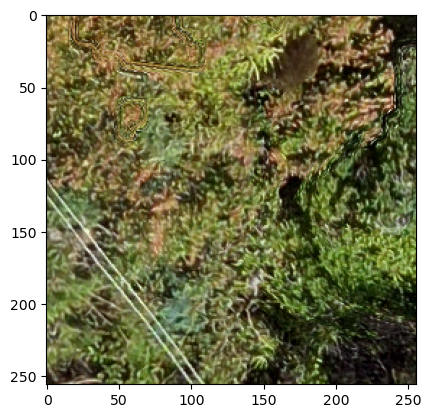

In [22]:
plt.imshow(image[0])
plt.show()

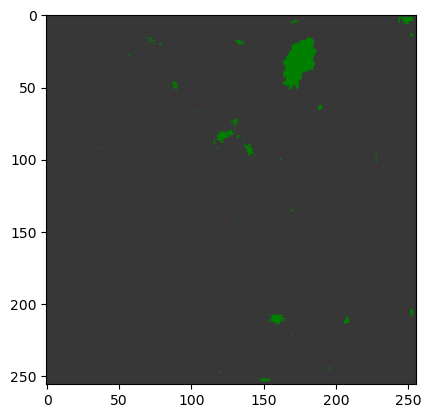

In [23]:
final_image = np.array(final_image, dtype=np.uint8)

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()

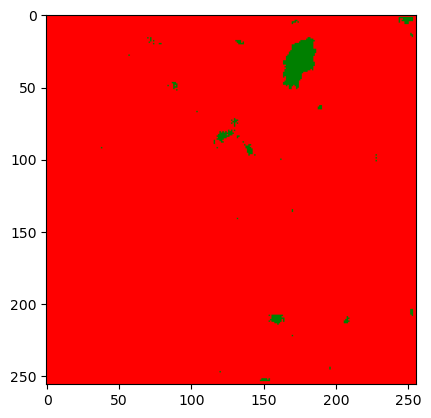

In [24]:
# Crear una máscara para los píxeles que son verdes o grises
mask_combined = np.logical_and(mask_vegetacion, mask_linea_electrica)
mask_combined = np.squeeze(mask_combined)

# Convertir la imagen a un array de numpy y cambiar el tipo de dato a uint8
final_image = np.array(final_image, dtype=np.uint8)

# Aplicar la máscara a la imagen original
final_image[mask_combined, :] = [255, 0, 0]  # Rojo: [R, G, B]

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


### **Using DeepLab**

In [15]:
models_dict = {'DeepLab': DeeplabV3Plus(image_size)}
loss_dict = {'tversky': tversky_loss_fn}
path = '/kaggle/input/tesellated-without-augmentation/TESELLATED_WITHOUT_AUGMENTATION'
loss = LossFunctions.tversky_loss
epochs = 15
batch_size = 8

for model_name, model in models_dict.items():
    for loss_name, loss in loss_dict.items():
            run_models(path,model, loss, epochs, batch_size)

Epoch 1/15
66/66 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.7951 - auc_1: 0.8691 - sensitivity_at_specificity_1: 0.9546 - specificity_at_sensitivity_1: 0.9258
Epoch 1: val_loss did not improve from inf
66/66 [==============================] - 53s 291ms/step - loss: 0.3562 - accuracy: 0.7951 - auc_1: 0.8691 - sensitivity_at_specificity_1: 0.9546 - specificity_at_sensitivity_1: 0.9258 - val_loss: nan - val_accuracy: 0.3566 - val_auc_1: 0.5000 - val_sensitivity_at_specificity_1: 0.0000e+00 - val_specificity_at_sensitivity_1: 0.0000e+00 - lr: 0.0010
Epoch 2/15
66/66 [==============================] - ETA: 0s - loss: 0.3172 - accuracy: 0.8337 - auc_1: 0.9076 - sensitivity_at_specificity_1: 0.9728 - specificity_at_sensitivity_1: 0.9585
Epoch 2: val_loss did not improve from inf
66/66 [==============================] - 17s 257ms/step - loss: 0.3172 - accuracy: 0.8337 - auc_1: 0.9076 - sensitivity_at_specificity_1: 0.9728 - specificity_at_sensitivity_1: 0.9585 - va

Load models to predict

In [16]:
!ls /kaggle/working/models

TESELLATED_WITH_GEOMETRIC_AUGMENTATION_DeepLab_tversky_power.h5
TESELLATED_WITH_GEOMETRIC_AUGMENTATION_DeepLab_tversky_veg.h5


In [ ]:
from keras.models import Sequential, load_model


dataset_name = 'TESELLATED_WITHOUT_AUGMENTATION'
model_name = 'DeepLab'
loss_name = 'tversky'

# Load model with registered custom objects
model_veg = tf.keras.models.load_model(f'TESELLATED_WITHOUT_AUGMENTATION{dataset_name}_{model_name}_{loss_name}_veg.h5', custom_objects=custom_objects)
model_power = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_power.h5', custom_objects=custom_objects)

train_batches_veg, validation_batches_veg, test_batches_veg = dataset_creation(path, class_train = 'vegetation', batch_size = 8)
train_batches_power, validation_batches_power, test_batches_power = dataset_creation(path, class_train = 'powerline', batch_size = 8)

#### **Metrics for power_line**

In [44]:
metrics_models(model = model_power, type_prediction = 'power_line', test_batches = test_batches_power)

1/1 [==============================] - 2s 2s/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.94583 - 0.89971
power_line     : 0.19164 - 0.10816
-----------------------------------
Mean           : 0.56873 - 0.50393


In [ ]:
show_predictions(dataset = test_batches_power, model = model_power, num = 5)

#### **Metrics for vegetation**

In [45]:
metrics_models(model = model_veg, type_prediction = 'vegetation', test_batches = test_batches_veg)

1/1 [==============================] - 0s 33ms/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.74849 - 0.63103
vegetation     : 0.88152 - 0.80279
-----------------------------------
Mean           : 0.81500 - 0.71691


In [ ]:
show_predictions(dataset = test_batches_veg, model = model_veg, num = 5)

## **Union of both models**

In [53]:
import tensorflow as tf
import cv2
import numpy as np

# Cargar los pesos pre-entrenados de las dos redes neuronales
#model_vegetacion = tf.keras.models.load_model("modelo_vegetacion.h5")
#model_linea_electrica = tf.keras.models.load_model("modelo_linea_electrica.h5")

for image, mask in test_batches_veg.skip(5).take(1):

    # Realizar la segmentación semántica para obtener las dos máscaras
    mask_vegetacion = model_veg.predict(image)
    mask_vegetacion = create_mask(mask_vegetacion, threshold=0.25)
    mask_linea_electrica = model_power.predict(image)
    mask_linea_electrica = create_mask(mask_linea_electrica, threshold=0.25)

1/1 [==============================] - 0s 33ms/step


In [54]:
combined_mask = np.zeros_like(image.numpy()[0])
combined_mask[np.squeeze(mask_vegetacion == 1), :] = (0, 255, 0) # verde para mask_vegetacion
combined_mask[np.squeeze(mask_linea_electrica == 1), :] = (110, 110, 110) # gris para mask_linea_electrica
final_image = cv2.addWeighted(image.numpy()[0], 0.5, combined_mask, 0.5, 0)

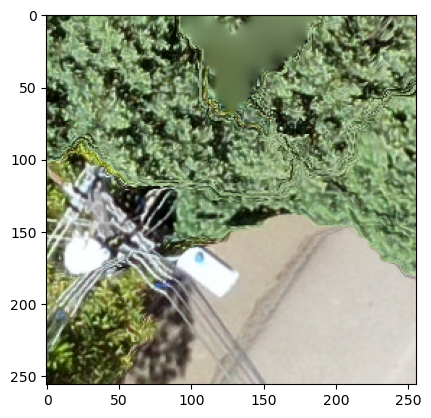

In [55]:
plt.imshow(image[0])
plt.show()

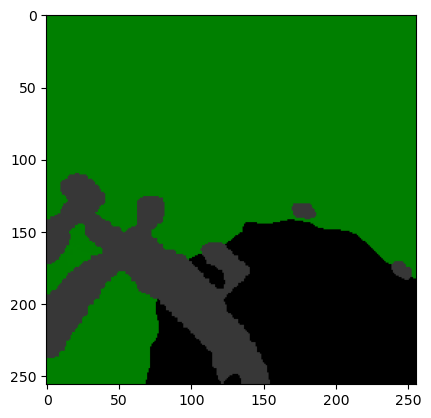

In [56]:
final_image = np.array(final_image, dtype=np.uint8)

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()

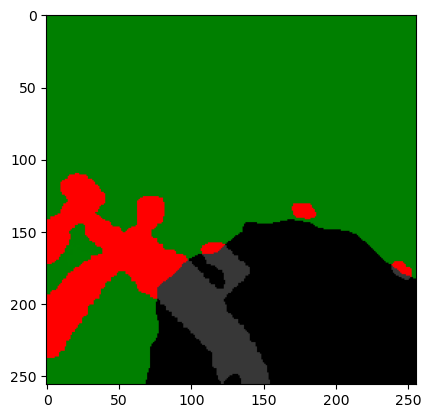

In [57]:
# Crear una máscara para los píxeles que son verdes o grises
mask_combined = np.logical_and(mask_vegetacion, mask_linea_electrica)
mask_combined = np.squeeze(mask_combined)

# Convertir la imagen a un array de numpy y cambiar el tipo de dato a uint8
final_image = np.array(final_image, dtype=np.uint8)

# Aplicar la máscara a la imagen original
final_image[mask_combined, :] = [255, 0, 0]  # Rojo: [R, G, B]

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


### **tesellated-with-spectral-augmentation**

In [36]:
models_dict = {'unet': Unet(image_size)}
loss_dict = {'tversky': tversky_loss_fn}
path = '/kaggle/input/tesellated-with-spectral-augmentation/TESELLATED_WITH_SPECTRAL_AUGMENTATION'
loss = LossFunctions.tversky_loss
epochs = 15
batch_size = 8

for model_name, model in models_dict.items():
    for loss_name, loss in loss_dict.items():
            run_models(path,model, loss, epochs, batch_size)

Epoch 1/15
465/465 [==============================] - ETA: 0s - loss: 0.3406 - accuracy: 0.7372 - auc_1: 0.7974 - sensitivity_at_specificity_1: 0.9272 - specificity_at_sensitivity_1: 0.8371
Epoch 1: val_loss improved from inf to 0.22612, saving model to /kaggle/working/models/TESELLATED_WITH_SPECTRAL_AUGMENTATION_vgg_tversky_veg.h5
465/465 [==============================] - 274s 555ms/step - loss: 0.3406 - accuracy: 0.7372 - auc_1: 0.7974 - sensitivity_at_specificity_1: 0.9272 - specificity_at_sensitivity_1: 0.8371 - val_loss: 0.2261 - val_accuracy: 0.7640 - val_auc_1: 0.7621 - val_sensitivity_at_specificity_1: 0.9057 - val_specificity_at_sensitivity_1: 0.7605 - lr: 0.0010
Epoch 2/15
465/465 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.7337 - auc_1: 0.8124 - sensitivity_at_specificity_1: 0.9422 - specificity_at_sensitivity_1: 0.8535
Epoch 2: val_loss improved from 0.22612 to 0.19568, saving model to /kaggle/working/models/TESELLATED_WITH_SPECTRAL_AUGMENTATION

Load models to predict

In [14]:
from keras.models import Sequential, load_model


dataset_name = 'TESELLATED_WITH_SPECTRAL_AUGMENTATION'
model_name = 'unet'
loss_name = 'tversky'

# Load model with registered custom objects
model_veg = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_veg.h5', custom_objects=custom_objects)
model_power = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_power.h5', custom_objects=custom_objects)

train_batches_veg, validation_batches_veg, test_batches_veg = dataset_creation(path, class_train = 'vegetation', batch_size = 8)
train_batches_power, validation_batches_power, test_batches_power = dataset_creation(path, class_train = 'powerline', batch_size = 8)

#### **Metrics for power_line**

In [16]:
metrics_models(model = model_power, type_prediction = 'power_line', test_batches = test_batches_power)

1/1 [==============================] - 3s 3s/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.98650 - 0.97354
power_line     : 0.39692 - 0.25352
-----------------------------------
Mean           : 0.69171 - 0.61353


In [ ]:
show_predictions(dataset = test_batches_power, model = model_power, num = 5)

#### **Metrics for vegetation**

In [18]:
metrics_models(model = model_veg, type_prediction = 'vegetation', test_batches = test_batches_veg)

1/1 [==============================] - 0s 26ms/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.48605 - 0.35837
vegetation     : 0.81381 - 0.71129
-----------------------------------
Mean           : 0.64993 - 0.53483


In [ ]:
show_predictions(dataset = test_batches_veg, model = model_veg, num = 5)

## **Union of both models**

In [37]:
import tensorflow as tf
import cv2
import numpy as np

# Cargar los pesos pre-entrenados de las dos redes neuronales
#model_vegetacion = tf.keras.models.load_model("modelo_vegetacion.h5")
#model_linea_electrica = tf.keras.models.load_model("modelo_linea_electrica.h5")

for image, mask in test_batches_veg.skip(100).take(1):

    # Realizar la segmentación semántica para obtener las dos máscaras
    mask_vegetacion = model_veg.predict(image)
    mask_vegetacion = create_mask(mask_vegetacion, threshold=0.25)
    mask_linea_electrica = model_power.predict(image)
    mask_linea_electrica = create_mask(mask_linea_electrica, threshold=0.25)

In [38]:
combined_mask = np.zeros_like(image.numpy()[0])
combined_mask[np.squeeze(mask_vegetacion == 1), :] = (0, 255, 0) # verde para mask_vegetacion
combined_mask[np.squeeze(mask_linea_electrica == 1), :] = (110, 110, 110) # gris para mask_linea_electrica
final_image = cv2.addWeighted(image.numpy()[0], 0.5, combined_mask, 0.5, 0)

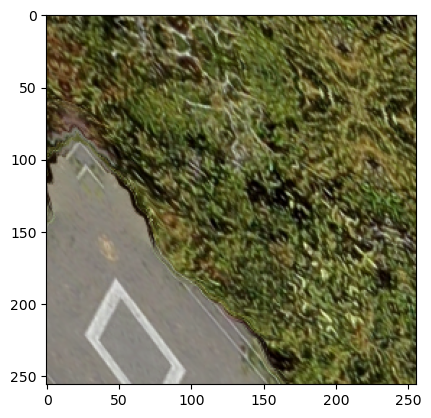

In [39]:
plt.imshow(image[0])
plt.show()

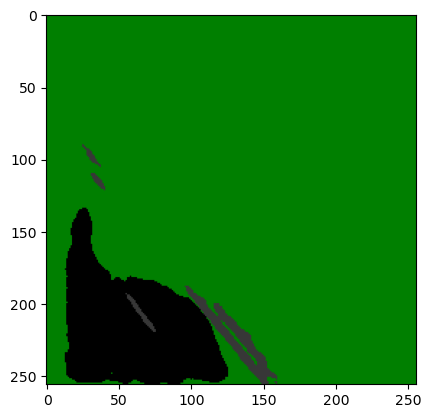

In [36]:
final_image = np.array(final_image, dtype=np.uint8)

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()

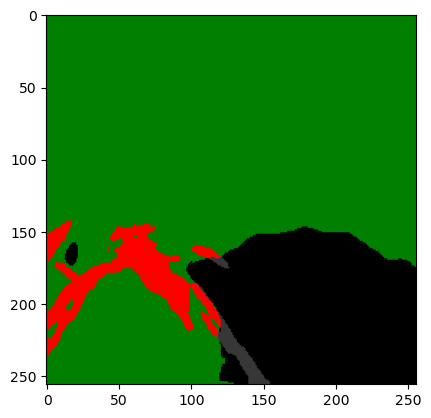

In [32]:
# Crear una máscara para los píxeles que son verdes o grises
mask_combined = np.logical_and(mask_vegetacion, mask_linea_electrica)
mask_combined = np.squeeze(mask_combined)

# Convertir la imagen a un array de numpy y cambiar el tipo de dato a uint8
final_image = np.array(final_image, dtype=np.uint8)

# Aplicar la máscara a la imagen original
final_image[mask_combined, :] = [255, 0, 0]  # Rojo: [R, G, B]

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


### **VGG Unet**

In [25]:
models_dict = {'vgg': VGGUnet(image_size)}
loss_dict = {'tversky': tversky_loss_fn}
path = '/kaggle/input/tesellated-with-spectral-augmentation/TESELLATED_WITH_SPECTRAL_AUGMENTATION'
loss = LossFunctions.tversky_loss
epochs = 15
batch_size = 8

for model_name, model in models_dict.items():
    for loss_name, loss in loss_dict.items():
            run_models(path,model, loss, epochs, batch_size)

Epoch 1/15
465/465 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.7591 - auc_1: 0.8222 - sensitivity_at_specificity_1: 0.9411 - specificity_at_sensitivity_1: 0.8673
Epoch 1: val_loss improved from inf to 0.27696, saving model to /kaggle/working/models/TESELLATED_WITH_SPECTRAL_AUGMENTATION_vgg_tversky_veg.h5
465/465 [==============================] - 276s 560ms/step - loss: 0.3318 - accuracy: 0.7591 - auc_1: 0.8222 - sensitivity_at_specificity_1: 0.9411 - specificity_at_sensitivity_1: 0.8673 - val_loss: 0.2770 - val_accuracy: 0.7381 - val_auc_1: 0.8018 - val_sensitivity_at_specificity_1: 0.9232 - val_specificity_at_sensitivity_1: 0.8551 - lr: 0.0010
Epoch 2/15
465/465 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.7659 - auc_1: 0.8392 - sensitivity_at_specificity_1: 0.9544 - specificity_at_sensitivity_1: 0.8781
Epoch 2: val_loss did not improve from 0.27696
465/465 [==============================] - 251s 540ms/step - loss: 0.2659 - accur

Load models to predict

In [27]:
!ls /kaggle/working/models

TESELLATED_WITHOUT_AUGMENTATION_vgg_tversky_power.h5
TESELLATED_WITHOUT_AUGMENTATION_vgg_tversky_veg.h5
TESELLATED_WITH_SPECTRAL_AUGMENTATION_vgg_tversky_power.h5
TESELLATED_WITH_SPECTRAL_AUGMENTATION_vgg_tversky_veg.h5


In [28]:
from keras.models import Sequential, load_model


dataset_name = 'TESELLATED_WITH_SPECTRAL_AUGMENTATION'
model_name = 'vgg'
loss_name = 'tversky'

# Load model with registered custom objects
model_veg = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_veg.h5', custom_objects=custom_objects)
model_power = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_power.h5', custom_objects=custom_objects)

train_batches_veg, validation_batches_veg, test_batches_veg = dataset_creation(path, class_train = 'vegetation', batch_size = 8)
train_batches_power, validation_batches_power, test_batches_power = dataset_creation(path, class_train = 'powerline', batch_size = 8)

#### **Metrics for power_line**

In [29]:
metrics_models(model = model_power, type_prediction = 'power_line', test_batches = test_batches_power)

1/1 [==============================] - 3s 3s/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.95623 - 0.91717
power_line     : 0.20034 - 0.11371
-----------------------------------
Mean           : 0.57828 - 0.51544


In [ ]:
show_predictions(dataset = test_batches_power, model = model_power, num = 5)

#### **Metrics for vegetation**

In [ ]:
metrics_models(model = model_veg, type_prediction = 'vegetation', test_batches = test_batches_veg)

In [ ]:
show_predictions(dataset = test_batches_veg, model = model_veg, num = 5)

## **Union of both models**

In [31]:
import tensorflow as tf
import cv2
import numpy as np

# Cargar los pesos pre-entrenados de las dos redes neuronales
#model_vegetacion = tf.keras.models.load_model("modelo_vegetacion.h5")
#model_linea_electrica = tf.keras.models.load_model("modelo_linea_electrica.h5")

for image, mask in test_batches_veg.skip(10).take(1):

    # Realizar la segmentación semántica para obtener las dos máscaras
    mask_vegetacion = model_veg.predict(image)
    mask_vegetacion = create_mask(mask_vegetacion, threshold=0.25)
    mask_linea_electrica = model_power.predict(image)
    mask_linea_electrica = create_mask(mask_linea_electrica, threshold=0.25)

1/1 [==============================] - 0s 27ms/step


In [32]:
combined_mask = np.zeros_like(image.numpy()[0])
combined_mask[np.squeeze(mask_vegetacion == 1), :] = (0, 255, 0) # verde para mask_vegetacion
combined_mask[np.squeeze(mask_linea_electrica == 1), :] = (110, 110, 110) # gris para mask_linea_electrica
final_image = cv2.addWeighted(image.numpy()[0], 0.5, combined_mask, 0.5, 0)

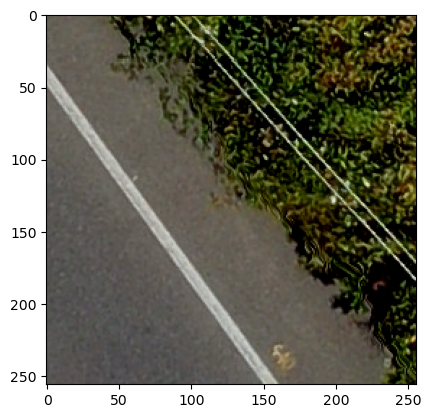

In [33]:
plt.imshow(image[0])
plt.show()

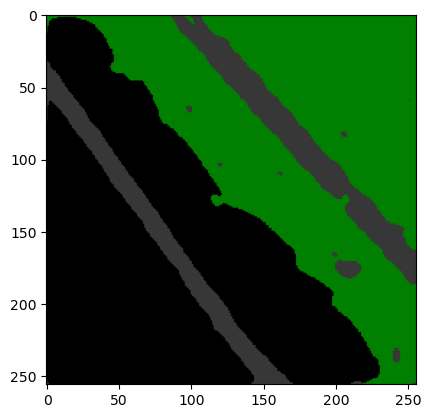

In [34]:
final_image = np.array(final_image, dtype=np.uint8)

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()

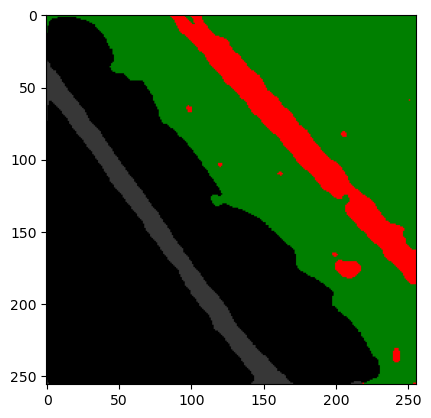

In [35]:
# Crear una máscara para los píxeles que son verdes o grises
mask_combined = np.logical_and(mask_vegetacion, mask_linea_electrica)
mask_combined = np.squeeze(mask_combined)

# Convertir la imagen a un array de numpy y cambiar el tipo de dato a uint8
final_image = np.array(final_image, dtype=np.uint8)

# Aplicar la máscara a la imagen original
final_image[mask_combined, :] = [255, 0, 0]  # Rojo: [R, G, B]

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


### **Using DeepLab**

In [23]:
models_dict = {'DeepLab': DeeplabV3Plus(image_size)}
loss_dict = {'tversky': tversky_loss_fn}
path = '/kaggle/input/tesellated-with-spectral-augmentation/TESELLATED_WITH_SPECTRAL_AUGMENTATION'
loss = LossFunctions.tversky_loss
epochs = 15
batch_size = 8

for model_name, model in models_dict.items():
    for loss_name, loss in loss_dict.items():
            run_models(path,model, loss, epochs, batch_size)

Epoch 1/15
465/465 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.8229 - auc_2: 0.8814 - sensitivity_at_specificity_2: 0.9672 - specificity_at_sensitivity_2: 0.9166
Epoch 1: val_loss improved from inf to 0.66694, saving model to /kaggle/working/models/TESELLATED_WITH_SPECTRAL_AUGMENTATION_DeepLab_tversky_veg.h5
465/465 [==============================] - 148s 247ms/step - loss: 0.3033 - accuracy: 0.8229 - auc_2: 0.8814 - sensitivity_at_specificity_2: 0.9672 - specificity_at_sensitivity_2: 0.9166 - val_loss: 0.6669 - val_accuracy: 0.3718 - val_auc_2: 0.5499 - val_sensitivity_at_specificity_2: 0.5435 - val_specificity_at_sensitivity_2: 0.5290 - lr: 0.0010
Epoch 2/15
465/465 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.8258 - auc_2: 0.8911 - sensitivity_at_specificity_2: 0.9715 - specificity_at_sensitivity_2: 0.9186
Epoch 2: val_loss improved from 0.66694 to 0.40954, saving model to /kaggle/working/models/TESELLATED_WITH_SPECTRAL_AUGMENTA

Load models to predict

In [24]:
from keras.models import Sequential, load_model


dataset_name = 'TESELLATED_WITH_SPECTRAL_AUGMENTATION'
model_name = 'DeepLab'
loss_name = 'tversky'

# Load model with registered custom objects
model_veg = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_veg.h5', custom_objects=custom_objects)
model_power = tf.keras.models.load_model(f'/kaggle/working/models/{dataset_name}_{model_name}_{loss_name}_power.h5', custom_objects=custom_objects)

train_batches_veg, validation_batches_veg, test_batches_veg = dataset_creation(path, class_train = 'vegetation', batch_size = 8)
train_batches_power, validation_batches_power, test_batches_power = dataset_creation(path, class_train = 'powerline', batch_size = 8)

#### **Metrics for power_line**

In [25]:
metrics_models(model = model_power, type_prediction = 'power_line', test_batches = test_batches_power)

1/1 [==============================] - 1s 1s/step
Class           F1         Jaccard   
-----------------------------------
background     : 0.95689 - 0.91826
power_line     : 0.19659 - 0.11143
-----------------------------------
Mean           : 0.57674 - 0.51485


In [ ]:
show_predictions(dataset = test_batches_power, model = model_power, num = 5)

#### **Metrics for vegetation**

In [ ]:
metrics_models(model = model_veg, type_prediction = 'vegetation', test_batches = test_batches_veg)

In [ ]:
show_predictions(dataset = test_batches_veg, model = model_veg, num = 5)

## **Union of both models**

In [32]:
import tensorflow as tf
import cv2
import numpy as np

# Cargar los pesos pre-entrenados de las dos redes neuronales
#model_vegetacion = tf.keras.models.load_model("modelo_vegetacion.h5")
#model_linea_electrica = tf.keras.models.load_model("modelo_linea_electrica.h5")

for image, mask in test_batches_veg.skip(4).take(1):

    # Realizar la segmentación semántica para obtener las dos máscaras
    mask_vegetacion = model_veg.predict(image)
    mask_vegetacion = create_mask(mask_vegetacion, threshold=0.25)
    mask_linea_electrica = model_power.predict(image)
    mask_linea_electrica = create_mask(mask_linea_electrica, threshold=0.25)

1/1 [==============================] - 0s 35ms/step


In [34]:
combined_mask = np.zeros_like(image.numpy()[0])
combined_mask[np.squeeze(mask_vegetacion == 1), :] = (0, 255, 0) # verde para mask_vegetacion
combined_mask[np.squeeze(mask_linea_electrica == 1), :] = (110, 110, 110) # gris para mask_linea_electrica
final_image = cv2.addWeighted(image.numpy()[0], 0.5, combined_mask, 0.5, 0)

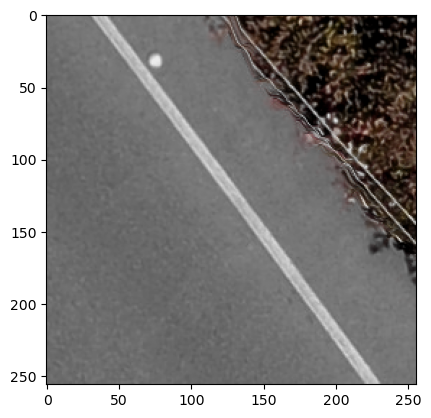

In [35]:
plt.imshow(image[0])
plt.show()

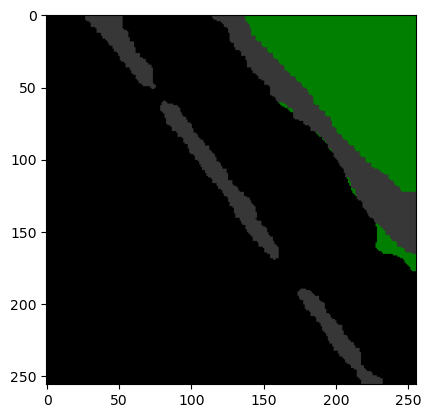

In [36]:
final_image = np.array(final_image, dtype=np.uint8)

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()

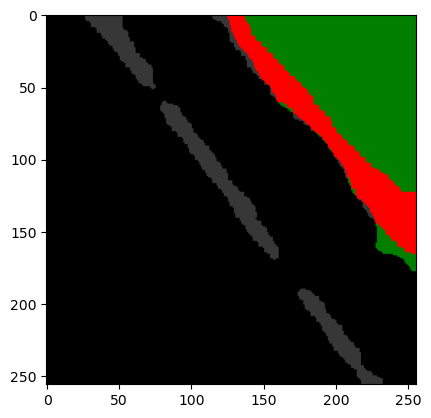

In [37]:
# Crear una máscara para los píxeles que son verdes o grises
mask_combined = np.logical_and(mask_vegetacion, mask_linea_electrica)
mask_combined = np.squeeze(mask_combined)

# Convertir la imagen a un array de numpy y cambiar el tipo de dato a uint8
final_image = np.array(final_image, dtype=np.uint8)

# Aplicar la máscara a la imagen original
final_image[mask_combined, :] = [255, 0, 0]  # Rojo: [R, G, B]

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


# **Initial Approach**

## **Creating new mask folders**

### **MASK_NEW_VEGETATION**

In [ ]:
import cv2
import os

# Definir la ruta de la carpeta con las máscaras
folder_path = "/kaggle/input/tesellated-with-geometric-augmentation/TESELLATED_WITH_GEOMETRIC_AUGMENTATION/MASK"

# Crear una nueva carpeta para las imágenes binarias
binary_folder_path = "/kaggle/working/MASK_NEW_VEGETATION"

if not os.path.exists(binary_folder_path):
    os.mkdir(binary_folder_path)

# Leer cada archivo en la carpeta y procesar
for filename in os.listdir(folder_path):
  # Cargar la imagen y convertir a escala de grises
  img = cv2.imread(os.path.join(folder_path, filename))
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Aplicar la umbralización
  _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

  # Convertir los píxeles verde (vegetación) en blanco y los píxeles grises (líneas eléctricas) en negro
  thresh[(img[:, :, 1] == 255) & (img[:, :, 0] == 0)] = 255
  thresh[(img[:, :, 0] == img[:, :, 1]) & (img[:, :, 0] == img[:, :, 2]) & (img[:, :, 0] != 0)] = 0

  # Guardar la imagen binaria en la nueva carpeta
  cv2.imwrite(os.path.join(binary_folder_path, filename), thresh)

### **MASK_NEW_POWERLINE**

In [ ]:
import cv2
import os

# Definir la ruta de la carpeta con las máscaras
folder_path = "/kaggle/input/tesellated-with-geometric-augmentation/TESELLATED_WITH_GEOMETRIC_AUGMENTATION/MASK"

# Crear una nueva carpeta para las imágenes binarias
binary_folder_path = "/kaggle/working/MASK_NEW_POWERLINE"

if not os.path.exists(binary_folder_path):
    os.mkdir(binary_folder_path)

# Leer cada archivo en la carpeta y procesar
for filename in os.listdir(folder_path):
  # Cargar la imagen y convertir a escala de grises
  img = cv2.imread(os.path.join(folder_path, filename))
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Aplicar la umbralización
  _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

  # Convertir los píxeles (110, 110, 110) en blanco y todo lo demás en negro
  thresh[(img[:, :, 0] == 110) & (img[:, :, 1] == 110) & (img[:, :, 2] == 110)] = 255
  thresh[(img[:, :, 0] != 110) | (img[:, :, 1] != 110) | (img[:, :, 2] != 110)] = 0

  # Guardar la imagen binaria en la nueva carpeta
  cv2.imwrite(os.path.join(binary_folder_path, filename), thresh)

## **Creating loss functions**

In [ ]:
import tensorflow.keras.backend as K

class LossFunctions:
    @staticmethod
    def tversky(y_true, y_pred):
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1-y_pred_pos))
        false_pos = K.sum((1-y_true_pos)*y_pred_pos)
        alpha = 0.7
        smooth = 1e-5
        return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

    @staticmethod
    def tversky_loss(y_true, y_pred):
        return 1 - LossFunctions.tversky(y_true,y_pred)

In [ ]:
import tensorflow.keras.backend as K

def categorical_focal_loss(gamma=2.0, alpha_val=None):
    def focal_loss(y_true, y_pred):
        """
        Categorical focal loss function.
        :param y_true: one-hot encoded true labels
        :param y_pred: predicted label probabilities
        :param gamma:
        :param alpha:
        :return:
        """
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)

        if alpha_val is not None:
            alpha = K.constant(alpha_val)
            class_weights = K.sum(alpha * y_true, axis=-1)
            class_weights = K.expand_dims(class_weights, axis=-1)
            focal_weights = class_weights * K.pow(1 - y_pred, gamma)
            loss = focal_weights * cross_entropy
        else:
            focal_weights = K.pow(1 - y_pred, gamma)
            loss = focal_weights * cross_entropy

        return K.mean(loss)

    return focal_loss

In [ ]:
import tensorflow.keras.backend as K

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pos_weight = alpha * y_true + (1 - alpha) * (1 - y_true)
        focal_weights = pos_weight * K.pow(1 - y_pred, gamma)
        loss = focal_weights * K.binary_crossentropy(y_true, y_pred)
        return K.mean(loss)
    return focal_loss

In [ ]:
import tensorflow.keras.backend as K

def weighted_binary_crossentropy(pos_weight=0.25):
    def weighted_bce(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        loss = pos_weight * y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)
        return -K.mean(loss)
    return weighted_bce

## **Building dataset for only veg**

In [ ]:
# ruta a las carpetas de imágenes y máscaras
data_dir = pathlib.Path('/kaggle/input/tesellated-with-geometric-augmentation/TESELLATED_WITH_GEOMETRIC_AUGMENTATION/')
images_dir = data_dir / 'RGB'
data_mask_dir = pathlib.Path('/kaggle/working/')
masks_dir = data_mask_dir / "MASK_NEW_VEGETATION"

# obtener una lista de rutas de archivo para imágenes y máscaras
image_paths = sorted([str(path) for path in images_dir.glob('*.png')])
mask_paths = sorted([str(path) for path in masks_dir.glob('*.png')])

# crear un dataset a partir de las rutas de archivo
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

# definir una función para cargar y preprocesar las imágenes y máscaras
def load_and_preprocess_image(image_path, mask_path):
    # cargar la imagen y máscara
    image = tf.io.decode_png(tf.io.read_file(image_path))
    mask = tf.io.decode_png(tf.io.read_file(mask_path), channels=1)
    
    # normalizar la imagen y máscara
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    
    return image, mask

# aplicar la función de carga y preprocesamiento a cada par de rutas de archivo en el dataset
dataset = dataset.map(load_and_preprocess_image)

# dividir el dataset en conjuntos de entrenamiento, validación y prueba
total_samples = len(image_paths)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 100

In [ ]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

In [ ]:
print(train_size, val_size,test_size)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

In [ ]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## **Architecture U-Net**

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # dropout
    x = layers.Dropout(0.4)(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.4)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.4)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x
    
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(256,256,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    bottleneck = layers.Dropout(0.5)(bottleneck)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

def VGGUnet(image_size, vgg_weight_path=None):
    inputs = Input((image_size, image_size, 3))
    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(inputs, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    outputs = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from keras import backend as K
K.clear_session()

tversky_loss_fn = LossFunctions.tversky_loss
model_veg = VGGUnet(image_size = 256)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model_veg.compile(optimizer=Adam(), loss=tversky_loss_fn, metrics=metrics)


In [ ]:
unet_model = build_unet_model()
#unet_model.summary()

In [ ]:
#tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [ ]:
#%load_ext tensorboard

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="binary_crossentropy",
                   metrics=["accuracy"])

In [ ]:
NUM_EPOCHS = 10
#BATCH_SIZE = 16


STEPS_PER_EPOCH = total_samples // BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size // BATCH_SIZE // VAL_SUBSPLITS

tensorboard = TensorBoard(log_dir='logs/semantic_segmentation')
model_history = model_veg.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,
                               callbacks=[tensorboard])

In [ ]:
#%tensorboard --logdir logs

## **Visualization of predicion**

In [ ]:
def create_mask(pred_mask, threshold=0.3):
  pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
  pred_mask = tf.where(pred_mask > threshold, 1.0, 0.0)  # usar float para el threshold
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model_veg.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model_veg.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions(test_batches.skip(5), 5)

## **Metricas**

In [ ]:
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import f1_score, jaccard_score

""" Prediction & Evaluation """
SCORE = []
threshold = 0.3
num_classes = 2
classes = [
        "background", "vegetation"
    ]

for image, mask in test_batches:
    pred_mask = model_veg.predict(image)
    pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
    pred = tf.where(pred_mask > threshold, 1.0, 0.0)

    labels = list(np.unique(pred))
    flat_mask = tf.reshape(mask,[-1])
    flat_pred = tf.reshape(pred, [-1])
    
    mask_arr = flat_mask.numpy().flatten()
    pred_arr = flat_pred.numpy().flatten()


    """ Calculating the metrics values """
    f1_value = f1_score(mask_arr, pred_arr, labels=labels, average=None, zero_division=0)
    jac_value = jaccard_score(mask_arr, pred_arr, labels=labels, average=None, zero_division=0)

    SCORE.append([f1_value, jac_value])

score = np.array(SCORE)
score = np.mean(score, axis=0)

l = ["Class", "F1", "Jaccard"]
print(f"{l[0]:15s} {l[1]:10s} {l[2]:10s}")
print("-"*35)

for i in range(num_classes):
    class_name = classes[i]
    f1 = score[0, i]
    jac = score[1, i]
    dstr = f"{class_name:15s}: {f1:1.5f} - {jac:1.5f}"
    print(dstr)

print("-"*35)
class_mean = np.mean(score, axis=-1)
class_name = "Mean"

f1 = class_mean[0]
jac = class_mean[1]

dstr = f"{class_name:15s}: {f1:1.5f} - {jac:1.5f}"
print(dstr)

## **Building dataset for only powerline**

In [ ]:
# ruta a las carpetas de imágenes y máscaras
data_dir = pathlib.Path('/kaggle/input/tesellated-with-geometric-augmentation/TESELLATED_WITH_GEOMETRIC_AUGMENTATION/')
images_dir = data_dir / 'RGB'
data_mask_dir = pathlib.Path('/kaggle/working/')
masks_dir = data_mask_dir / "MASK_NEW_POWERLINE"

# obtener una lista de rutas de archivo para imágenes y máscaras
image_paths = sorted([str(path) for path in images_dir.glob('*.png')])
mask_paths = sorted([str(path) for path in masks_dir.glob('*.png')])

# crear un dataset a partir de las rutas de archivo
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

# definir una función para cargar y preprocesar las imágenes y máscaras
def load_and_preprocess_image(image_path, mask_path):
    # cargar la imagen y máscara
    image = tf.io.decode_png(tf.io.read_file(image_path))
    mask = tf.io.decode_png(tf.io.read_file(mask_path), channels=1)
    
    # normalizar la imagen y máscara
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    
    return image, mask

# aplicar la función de carga y preprocesamiento a cada par de rutas de archivo en el dataset
dataset = dataset.map(load_and_preprocess_image)

# dividir el dataset en conjuntos de entrenamiento, validación y prueba
total_samples = len(image_paths)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 100

In [ ]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

In [ ]:
print(train_size, val_size,test_size)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

In [ ]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## **Architecture U-Net**

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # dropout
    x = layers.Dropout(0.4)(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.4)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.4)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x
    
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(256,256,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    bottleneck = layers.Dropout(0.5)(bottleneck)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()
#unet_model.summary()

In [ ]:
#tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [ ]:
from keras import backend as K
K.clear_session()

tversky_loss_fn = LossFunctions.tversky_loss
model_powerline = VGGUnet(image_size = 256)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model_powerline.compile(optimizer=Adam(), loss=tversky_loss_fn, metrics=metrics)


In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 8


STEPS_PER_EPOCH = total_samples // BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size // BATCH_SIZE // VAL_SUBSPLITS

tensorboard = TensorBoard(log_dir='logs/semantic_segmentation')
model_history = model_powerline.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,
                               callbacks=[tensorboard])

## **Visualization of predicion**

In [ ]:
def create_mask(pred_mask, threshold=0.25):
  pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
  pred_mask = tf.where(pred_mask > threshold, 1.0, 0.0)  # usar float para el threshold
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model_powerline.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model_powerline.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions(test_batches.skip(5), 50)

## **Metricas**

In [ ]:
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import f1_score, jaccard_score

""" Prediction & Evaluation """
SCORE = []
threshold = 0.3
num_classes = 2
classes = [
        "background", "power_line"
    ]

for image, mask in test_batches:
    pred_mask = model_powerline.predict(image)
    pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
    pred = tf.where(pred_mask > threshold, 1.0, 0.0)

    labels = list(np.unique(pred))
    flat_mask = tf.reshape(mask,[-1])
    flat_pred = tf.reshape(pred, [-1])
    
    mask_arr = flat_mask.numpy().flatten()
    pred_arr = flat_pred.numpy().flatten()


    """ Calculating the metrics values """
    f1_value = f1_score(mask_arr, pred_arr, labels=labels, average=None, zero_division=0)
    jac_value = jaccard_score(mask_arr, pred_arr, labels=labels, average=None, zero_division=0)

    SCORE.append([f1_value, jac_value])

score = np.array(SCORE)
score = np.mean(score, axis=0)

l = ["Class", "F1", "Jaccard"]
print(f"{l[0]:15s} {l[1]:10s} {l[2]:10s}")
print("-"*35)

for i in range(num_classes):
    class_name = classes[i]
    f1 = score[0, i]
    jac = score[1, i]
    dstr = f"{class_name:15s}: {f1:1.5f} - {jac:1.5f}"
    print(dstr)

print("-"*35)
class_mean = np.mean(score, axis=-1)
class_name = "Mean"

f1 = class_mean[0]
jac = class_mean[1]

dstr = f"{class_name:15s}: {f1:1.5f} - {jac:1.5f}"
print(dstr)

# **Union of both models**

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

# Cargar los pesos pre-entrenados de las dos redes neuronales
#model_vegetacion = tf.keras.models.load_model("modelo_vegetacion.h5")
#model_linea_electrica = tf.keras.models.load_model("modelo_linea_electrica.h5")

for image, mask in test_batches.skip(2).take(1):

    # Realizar la segmentación semántica para obtener las dos máscaras
    mask_vegetacion = model_veg.predict(image)
    mask_vegetacion = create_mask(mask_vegetacion, threshold=0.25)
    mask_linea_electrica = model_powerline.predict(image)
    mask_linea_electrica = create_mask(mask_linea_electrica, threshold=0.25)

In [ ]:
combined_mask = np.zeros_like(image.numpy()[0])
combined_mask[np.squeeze(mask_vegetacion == 1), :] = (0, 255, 0) # verde para mask_vegetacion
combined_mask[np.squeeze(mask_linea_electrica == 1), :] = (128, 128, 128) # gris para mask_linea_electrica
final_image = cv2.addWeighted(image.numpy()[0], 0.5, combined_mask, 0.5, 0)

In [ ]:
np.unique(mask_linea_electrica)

In [ ]:
final_image = np.array(final_image, dtype=np.uint8)

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


In [ ]:
plt.imshow(image[0])

In [ ]:
# Crear una máscara para los píxeles que son verdes o grises
mask_combined = np.logical_and(mask_vegetacion, mask_linea_electrica)
mask_combined = np.squeeze(mask_combined)

# Convertir la imagen a un array de numpy y cambiar el tipo de dato a uint8
final_image = np.array(final_image, dtype=np.uint8)

# Aplicar la máscara a la imagen original
final_image[mask_combined, :] = [255, 0, 0]  # Rojo: [R, G, B]

# Visualizar la imagen resultante
plt.imshow(final_image)
plt.show()


In [ ]:
def create_mask(pred_mask, threshold=0.25):
  pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
  pred_mask = tf.where(pred_mask > threshold, 1.0, 0.0)  # usar float para el threshold
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask_power = model_powerline.predict(image)
            pred_mask_veg = model_veg.predict(image)

            display([image[0], create_mask(pred_mask_power)])
  

In [ ]:
show_predictions(test_batches.skip(2), 1)

In [ ]:
model_powerline.save('power_line_trained_model.h5')
model_veg.save('veg_trained_model.h5')


In [ ]:
# Register custom loss function
custom_objects = {'tversky_loss': LossFunctions.tversky_loss}

# Load model with registered custom objects
model_veg = tf.keras.models.load_model('veg_trained_model.h5', custom_objects=custom_objects)

# Use the model for prediction
predictions = model_veg.predict(image)

In [ ]:
from tensorflow.keras.models import load_model

model_powerline = load_model('power_line_trained_model.h5')
predictions = model_powerline.predict(image)